## Section 1.1: Writing style and dependency parsing

In [ ]:
# Check if we are running in Google Colab

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("This script is running in Google Colab.")
else:
    print("This script is not running in Google Colab.")

if IN_COLAB:
  # Mount the Google Drive
  # If running the notebook on your own local machine you do not need this.

  from google.colab import drive
  drive.mount('/content/drive/')
  home_contents = !ls 'drive/My Drive/'

This script is running in Google Colab.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#This is the requirements file I have included at part of the submission.
#It's used to create the raincloud plot with ptitprince.
#Here are the following package versions within the file:
#matplotlib==3.8
#numpy>=1.13
#scipy
#seaborn==0.11
!pip install -r '/content/drive/MyDrive/NLP/Coursework/requirements.txt'

In [ ]:
!pip install ptitprince

In [ ]:
#Import all necessary packages
import numpy as np
import pandas as pd
import os
import json
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
import ptitprince as pt
from collections import Counter
import spacy
from scipy.stats import mannwhitneyu, ttest_ind

#pathway to the stories
fn = '/content/drive/MyDrive/NLP/Coursework/stories.json'

#Open the story json file
with open(fn, 'r') as ifh:
  data = json.load(ifh)

stories = data['stories']

#Total number of stories
total_stories = len(stories)

print(f"Total number of stories is {total_stories}")

Total number of stories is 602


In [ ]:
stories[256]

{'index': 256,
 'theme': 'redemption',
 'setting': 'outer space',
 'person': 'spy',
 'style': 'descriptive',
 'outcome': 'defeat',
 'object_concept': 'cabbage',
 'story': "Among the cold, shimmering cosmos, as distant and indifferent as the ancient gods, there existed a woman of perplexing skill and obscurity. Enrobed in the cloak of constellations, she made her living on the precipice of ambiguity and secrecy, artfully navigating the labyrinthine corridors of subterfuge and manipulation. She was a whisper upon the lips of the unknown, a spirit who danced blithely among the shadows of the endless cosmic expanse.\\n\\nA task of paramount importance lay before her, a mission that carried the weight of countless lives. In the cataclysmic heart of interstellar turbulence, there dwelled an entity of terrifying power. Said to be crafted of pure starlight and quicksilver, the entity was a behemoth of celestial commotion, in its very essence a manifestation of cosmic discord. To tame, to contr

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def get_longest_dependency(text):
    #Load the english model
    nlp = spacy.load("en_core_web_sm")
    #Process the text
    doc = nlp(text)

    max_dep_list = []
    for sent in doc.sents:
        text_idx = []
        head_idx = []
        for token in sent:
            text_idx.append(token.i) #Get the index of each word in the sentence
            head_idx.append(token.head.i) #Get the index of head of each word

        #Dependency length of each dependency found by subtracting both lists
        depend_lengths = abs(np.array(text_idx) - np.array(head_idx))
        max_dep_list.append(np.max(depend_lengths))

    return np.mean(max_dep_list)

In [ ]:
#List created to store the average max dependicies for each story
avg_max_dep = []

for item in stories: #Retrieve each story from the dictionary
    if "story" in item:
        story = item['story']
        avg_max_dep.append(get_longest_dependency(story))

In [ ]:
#Iterate through all stories to obtain all story types and store in a list
style_list = []
for item in stories:
    if "style" in item:
        style_list.append(item['style'])

#Dataframe created from dictionary of story style and average max dependency
depend_dict = {'Style': style_list, 'Average Maximum Dependency': avg_max_dep}
depend_df = pd.DataFrame(depend_dict)
#Dataframe is grouped by the story style and the average is taken for dependency across each style
mean_depends_df = depend_df.groupby('Style').agg(avg_dependency = ('Average Maximum Dependency', 'mean'))
mean_depends_df.sort_values('avg_dependency', ascending = False)

,avg_dependency
Style,
descriptive,28.020674
poetic,23.485638
journalistic,18.673309
for children,13.548837
concise,6.760752


In [ ]:
depend_df.head()

,Style,Average Maximum Dependency
0,descriptive,23.250000
1,journalistic,16.125000
2,journalistic,17.950000
3,journalistic,17.117647
4,descriptive,45.444444


Text(0, 0.5, 'Style')

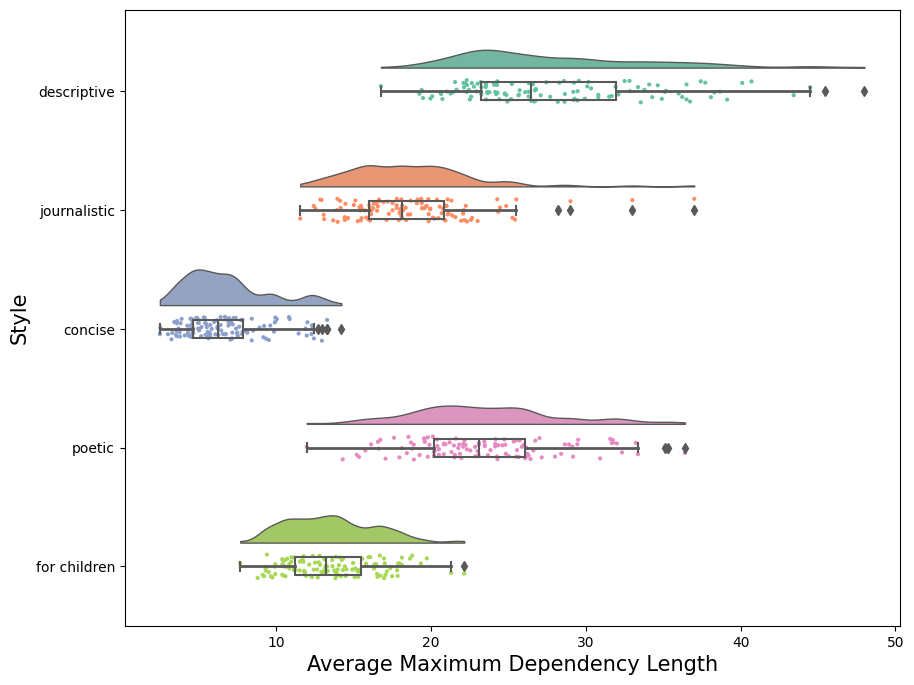

In [ ]:
#Create the raincloud plot which is a combination of violin plots, box plots and scatter plots
ort = "h"; pal = "Set2"; sigma = .2
fig, ax = plt.subplots(figsize=(10,8))
pt.RainCloud(x = 'Style', y = 'Average Maximum Dependency', data = depend_df, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort)
ax.set_xlabel("Average Maximum Dependency Length", fontsize = 15)
ax.set_ylabel("Style", fontsize = 15)

## Section 1.2: POS tagging

In [ ]:
def get_pos_freqs(text):
    #Load the english model
    nlp = spacy.load("en_core_web_sm")
    #Process the text
    doc = nlp(text)


    pos_tags = []
    for sentence in doc.sents:
        #Iterate through each token in each sentence and obtain the POS tags for each
        for token in sentence:
            pos_tags.append(token.pos_)

    return Counter(pos_tags) #The count of each pos tag is returned

In [ ]:
pos_list = []

for item in stories: #Retrieve each story from the dictionary
    if "story" in item:
        story = item['story']
        pos_list.append(get_pos_freqs(story))

In [ ]:
#Iterate through all stories to obtain all story outcomes and store in a list
outcome_list = []
for item in stories:
    if "outcome" in item:
        outcome_list.append(item['outcome'])

In [ ]:
#Dataframe created storing the count of each POS tag for each story along with the story style and outcome
pos_df = pd.DataFrame(pos_list)
pos_df["Style"] = style_list
pos_df["Story outcome"] = outcome_list
#For each story style the average count for each POS tag is found
pos_df_avg = pos_df.groupby('Style').agg(ADP_avg = ('ADP', 'mean'), DET_avg = ('DET', 'mean'), NOUN_avg = ('NOUN', 'mean'),
                            SCONJ_avg = ('SCONJ', 'mean'), AUX_avg = ('AUX', 'mean'), VERB_avg = ('VERB', 'mean'),
                            PROPN_avg = ('PROPN', 'mean'), CCONJ_avg = ('CCONJ', 'mean'), PUNCT_avg = ('PUNCT', 'mean'),
                            ADJ_avg = ('ADJ', 'mean'), PRON_avg = ('PRON', 'mean'), ADV_avg = ('ADV', 'mean'),
                            NUM_avg = ('NUM', 'mean'), PART_avg = ('PART', 'mean'), INTJ_avg = ('INTJ', 'mean'),
                            X_avg = ('X', 'mean'), SPACE_avg = ('SPACE', 'mean'), SYM_avg = ('SYM', 'mean')).round(0)

print(pos_df_avg)

              ADP_avg  DET_avg  NOUN_avg  SCONJ_avg  AUX_avg  VERB_avg  \
Style                                                                    
concise          31.0     33.0      81.0        2.0     10.0      46.0   
descriptive      69.0     62.0     124.0        4.0      9.0      58.0   
for children     37.0     39.0      76.0        6.0     19.0      58.0   
journalistic     54.0     54.0     108.0        4.0     13.0      54.0   
poetic           66.0     60.0     120.0        4.0      7.0      52.0   

              PROPN_avg  CCONJ_avg  PUNCT_avg  ADJ_avg  PRON_avg  ADV_avg  \
Style                                                                       
concise             8.0        4.0       63.0     22.0      33.0      8.0   
descriptive         5.0       12.0       55.0     47.0      35.0     14.0   
for children       18.0       15.0       56.0     32.0      43.0     19.0   
journalistic        9.0       11.0       53.0     36.0      32.0     12.0   
poetic             

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'ADP_avg'),
  Text(1, 0, 'DET_avg'),
  Text(2, 0, 'NOUN_avg'),
  Text(3, 0, 'PRON_avg'),
  Text(4, 0, 'ADJ_avg')])

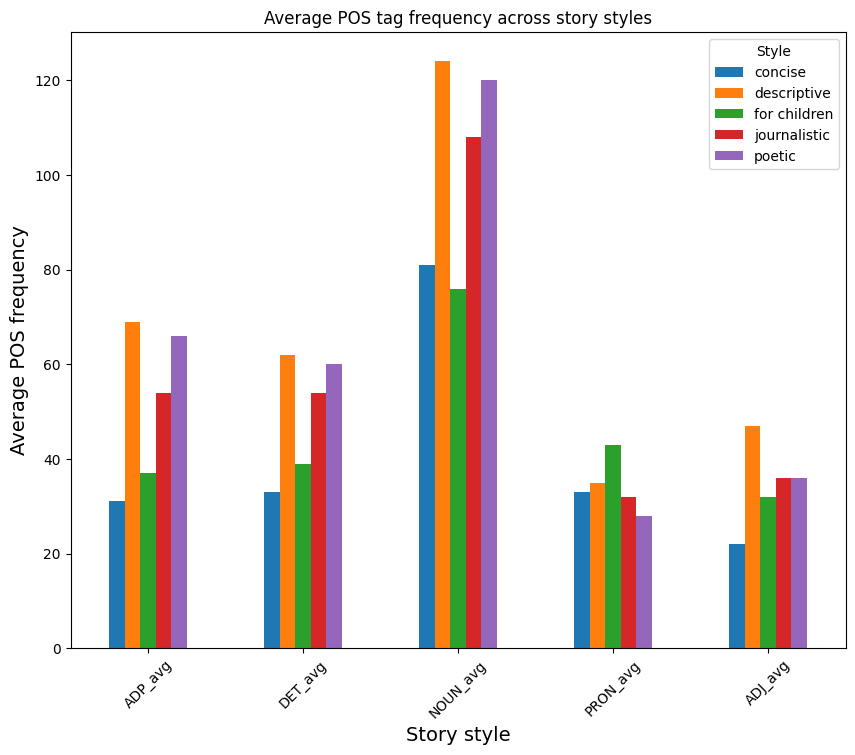

In [ ]:
#Bar plot created for POS tags that have the largest average count for the story style
pos_df_avg[['ADP_avg', 'DET_avg', 'NOUN_avg','PRON_avg', 'ADJ_avg']].T.plot(kind = 'bar', figsize = (10,8))
plt.title("Average POS tag frequency across story styles")
plt.ylabel("Average POS frequency", fontsize = 14)
plt.xlabel("Story style", fontsize = 14)
plt.xticks(rotation = 45)

In [ ]:
pos_df

,ADP,DET,NOUN,SCONJ,AUX,VERB,PROPN,CCONJ,PUNCT,ADJ,PRON,ADV,NUM,PART,INTJ,X,SPACE,SYM,Style,Story outcome
0,65,64,119,7.0,14.0,58,3.0,9.0,48,48,27,12,1.0,6.0,NaN,NaN,NaN,NaN,descriptive,defeat
1,46,56,102,4.0,7.0,47,7.0,10.0,48,48,21,7,1.0,11.0,NaN,NaN,NaN,NaN,journalistic,defeat
2,60,52,122,8.0,16.0,49,9.0,15.0,64,34,41,21,1.0,1.0,NaN,NaN,NaN,NaN,journalistic,victory
3,53,48,94,9.0,9.0,50,19.0,6.0,43,37,25,10,2.0,14.0,NaN,NaN,NaN,NaN,journalistic,victory
4,83,57,136,5.0,11.0,59,4.0,16.0,57,52,49,18,NaN,5.0,NaN,NaN,NaN,NaN,descriptive,victory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,51,42,98,2.0,12.0,43,14.0,15.0,46,42,33,8,NaN,9.0,NaN,NaN,NaN,NaN,journalistic,victory
598,79,65,135,1.0,9.0,55,6.0,13.0,56,22,19,5,2.0,4.0,NaN,NaN,NaN,NaN,poetic,victory
599,69,49,107,6.0,8.0,58,5.0,8.0,48,44,31,27,1.0,2.0,NaN,NaN,NaN,NaN,descriptive,defeat
600,29,29,46,5.0,21.0,50,28.0,10.0,48,23,43,12,1.0,9.0,NaN,NaN,NaN,NaN,for children,defeat


In [ ]:
for pos in list(pos_list[0].keys()):
    pos_victory = pos_df.loc[pos_df["Story outcome"] == "victory", pos]
    pos_defeat = pos_df.loc[pos_df["Story outcome"] == "defeat", pos]

    #Unpaired t-test performed between pos tags for victory and defeat stories
    U1, p = mannwhitneyu(pos_victory, pos_defeat, method = "auto")
    print(f"U test for {pos}:\np-value = {p}\n")

U test for ADP:
p-value = 0.7036746146169892

U test for DET:
p-value = 0.30576971970773414

U test for NOUN:
p-value = 0.5090580406263531

U test for SCONJ:
p-value = nan

U test for AUX:
p-value = nan

U test for VERB:
p-value = 0.464945495094371

U test for PROPN:
p-value = nan

U test for CCONJ:
p-value = nan

U test for PUNCT:
p-value = 0.08862874859909221

U test for ADJ:
p-value = 0.7886178335364732

U test for PRON:
p-value = 0.9848415838273035

U test for ADV:
p-value = 0.34464767641077343

U test for NUM:
p-value = nan

U test for PART:
p-value = nan



In [ ]:
victory_stories = pos_df.loc[pos_df["Story outcome"] == "victory"]
defeat_stories = pos_df.loc[pos_df["Story outcome"] == "defeat"]

pos_tags = ["VERB", "ADJ", "ADV", "NOUN", "DET"]

t_test_results = {}

for tag in pos_tags:
    t_stat, p_val = ttest_ind(victory_stories[tag], defeat_stories[tag], equal_var=False)
    t_test_results[tag] = {"t-statistic": t_stat, "p-value": p_val}

t_test_df = pd.DataFrame(t_test_results).T
print(t_test_df)

      t-statistic   p-value
VERB     0.811773  0.417244
ADJ     -0.156605  0.875609
ADV      1.359920  0.174372
NOUN     0.623428  0.533242
DET      1.100256  0.271667


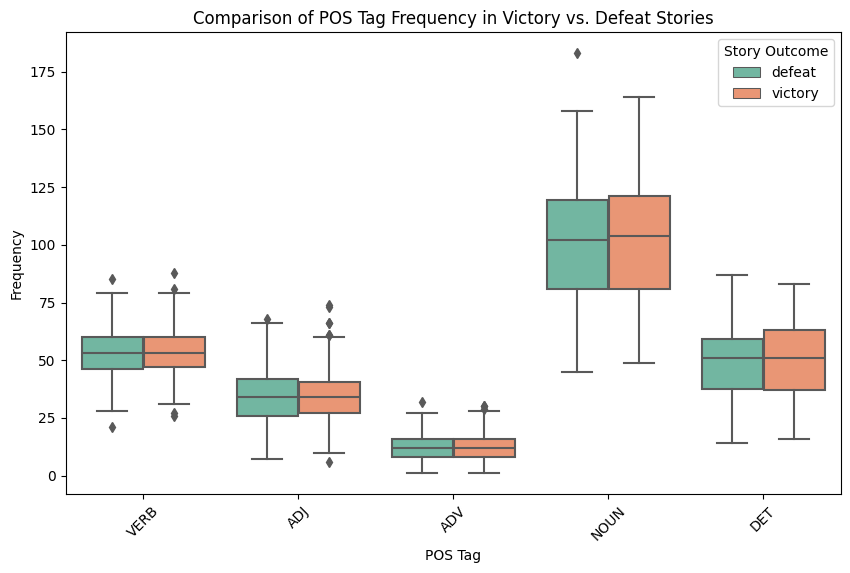

In [ ]:
plt.figure(figsize=(10, 6))
df_melted = pos_df.melt(id_vars=["Story outcome"], value_vars=pos_tags, var_name="POS Tag", value_name="Count")
sns.boxplot(x="POS Tag", y="Count", hue="Story outcome", data=df_melted, palette="Set2")
plt.title("Comparison of POS Tag Frequency in Victory vs. Defeat Stories")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.legend(title="Story Outcome")
plt.xticks(rotation=45)
plt.show()

<Figure size 800x500 with 0 Axes>

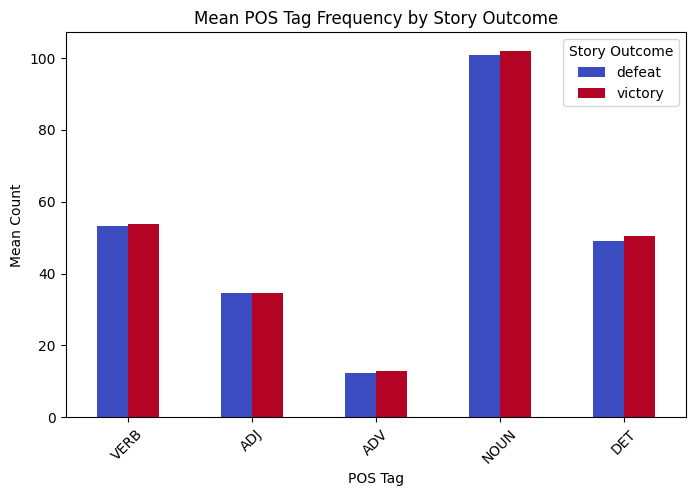

In [ ]:
plt.figure(figsize=(8, 5))
means = pos_df.groupby("Story outcome")[pos_tags].mean().T
means.plot(kind="bar", figsize=(8,5), colormap="coolwarm")
plt.title("Mean POS Tag Frequency by Story Outcome")
plt.xlabel("POS Tag")
plt.ylabel("Mean Count")
plt.xticks(rotation=45)
plt.legend(title="Story Outcome")
plt.show()